# Detekcja krawędzi


## Cel ćwiczenia

- Zapoznanie z metodami detekcji krawędzi:
  - Sobel, Prewitt, Roberts - przypomnienie,
  - Laplasjan z Gaussa (LoG – ang. Laplacian of Gaussian),
  - Canny.

Detekcja krawędzi przez wiele lat była podstawą algorytmów segmentacji.
Krawędzie wykrywane są najczęściej z wykorzystaniem pierwszej (gradient) i drugiej (Laplasjan) pochodnej przestrzennej.
Wykorzystanie obu metod zaprezentowane zostało w ćwiczeniu _Przetwarzanie wstępne. Filtracja kontekstowa_.

W niniejszym ćwiczeniu poznane detektory krawędzi zostaną porównane z bardziej zaawansowanymi: Laplasjan z funkcji Gaussa (LoG), Zero Crossing i Canny.


## Laplasjan z Gaussa (LoG)

Funkcja Gaussa:<br>
\begin{equation}
h(r) = e^{\frac{-r^2}{2 \sigma^2}}
\end{equation}<br>
gdzie:

- $r^2 = x^2 + y^2$
- $\sigma$ to odchylenie standardowe.

Działanie filtracji Gaussowskiej zostało przedstawione w ćwiczeniu "Przetwarzanie wstępne". W jej wyniku następuje rozmazanie obrazu.
Laplasjan tej funkcji dany jest wzorem:

\begin{equation}
\nabla^2 h(r) = \frac{r^2 - 2\sigma^2}{\sigma^4} e^{-\frac{r^2}{2\sigma^2}}
\end{equation}

Funkcję (z oczywistych powodów) nazywamy Laplasjan z Gaussa (LoG).
Ponieważ druga pochodna jest operacją liniową, konwolucja obrazu z $\nabla^2 h(r)$ daje taki sam efekt jak zastosowanie filtracji Gaussa na obrazie, a następnie obliczenie Laplasjanu z wyniku.
Lokalizacja krawędzi polega na znalezieniu miejsca, gdzie po filtracji LoG następuje zmiana znaku.


In [265]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import math
import os
import requests

url = "https://raw.githubusercontent.com/vision-agh/poc_sw/master/09_Canny/"

HOUSE_FILENAME = "dom.png"
for fileName in [HOUSE_FILENAME]:
    if not os.path.exists(fileName):
        r = requests.get(url + fileName, allow_redirects=True)
        open(fileName, "wb").write(r.content)


def show_grayscale_image(ax, image, title=None, full_scale: bool = False):
    vmin, vmax = (0, 256) if full_scale else (None, None)
    ax.axis("off")
    ax.imshow(image, cmap="gray", vmin=vmin, vmax=vmax)
    if ax == plt:
        plt.title(title)
    else:
        ax.set_title(title)

1. Wczytaj obraz _house.png_.
2. Wykonaj rozmycie Gaussowskie obrazu wejściowego.
   W tym celu wykorzysaj funkcję `cv2.GaussianBlur(img, kSize, sigma)`.
   Pierwszy argument jest obrazem wejśćiowym.
   Drugi jest rozmiarem filtru (podanym w nawiasach okrągłych, np. _(3, 3)_).
   Trzecim argumentem jest odchylenie standardowe. Wartość jest dobrana automatycznie, jeśli zosanie podana wartość `0` (będą równe rozmiarowi).


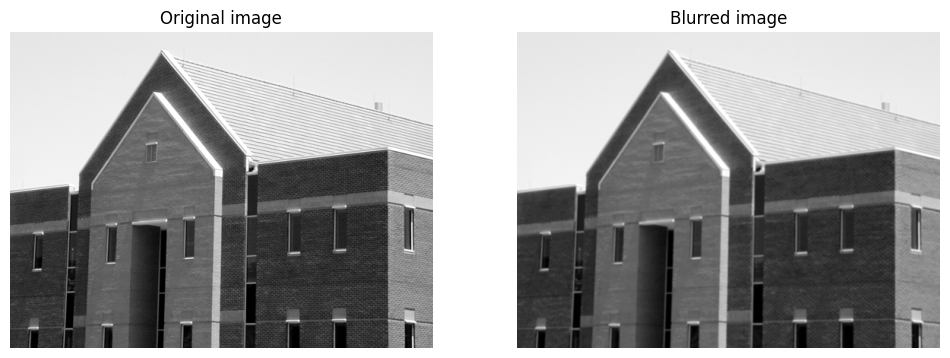

In [266]:
house_image = cv2.imread(HOUSE_FILENAME, cv2.IMREAD_GRAYSCALE)
blurred_image = cv2.GaussianBlur(house_image, ksize=(3, 3), sigmaX=0)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 8))

show_grayscale_image(ax1, house_image, title="Original image")
show_grayscale_image(ax2, blurred_image, title="Blurred image")

3. Oblicz laplasjan obrazu rozmytego.
   W tym celu wykorzysaj funkcję `cv2.Laplacian(img, ddepth)`.
   Pierszym argumentem jest obraz wejściowy.
   Drugim argumentem jest typ danych wejściowych. Użyj `cv2.CV_32F`.


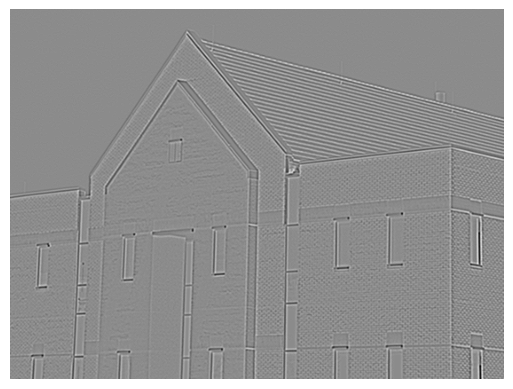

In [267]:
laplacian = cv2.Laplacian(blurred_image, ddepth=cv2.CV_32F)
show_grayscale_image(plt, laplacian)

4. Wyznacz miejsca zmiany znaku.
   Zaimplementuj funkcję `crossing(LoG, thr)`:
   - Najpierw stwórz tablicę, do której zostanie zapisany wynik.
     Jej rozmiar jest taki sam jak przetwarzanego obrazu.
   - Następnie wykonaj pętle po obrazie (bez ramki jednopikselowej).
     W każdej iteracji stwórz otoczenie o rozmiarze $3 \times 3$.
     Dla otoczenia oblicz wartość maksymalną i minimalną.
   - Jeśli wartości te mają przeciwne znaki, to do danego miejsca tablicy przypisz wartość:
   - jeśli piksel wejściowy > 0, to dodaj do niego wartość bezwzględną minimum.
   - jeśli piksel wejściowy < 0, to do jego wartości bezwzględnej dodaj maksimum.
   - Zmień zakres wykonanej tablicy do $<0, 255>$.
   - Wykonaj progowanie tablicy. Próg jest argumentem wejściowym.
   - Przeskaluj dane binarne do wartości `[0, 255]`.
   - Wykonaj konwersję do typu _uint8_.
   - Wykonaj rozmycie medianowe wyniku.
     Wykorzystaj funkcję `cv2.medianBlur(img, kSize)`.
     Pierwszym argumentem jest obraz wejściowy, a drugim rozmiar filtra.
   - Zwróć wyznaczoną tablicę.


In [268]:
def crossing(laplacian_of_gauss, threshold, median_blur_kernel_size=5):
    image_y, image_x = laplacian_of_gauss.shape
    result = np.zeros(shape=laplacian_of_gauss.shape, dtype=np.uint8)

    for y in range(1, image_y - 1):
        for x in range(1, image_x - 1):
            pixel_value = laplacian_of_gauss[y, x]
            surrounding = laplacian_of_gauss[y - 1 : y + 2, x - 1 : x + 2]
            min_value = np.min(surrounding)
            max_value = np.max(surrounding)

            if np.sign(min_value) != np.sign(max_value):
                if pixel_value > 0:
                    result[y][x] = pixel_value + np.abs(min_value)
                elif pixel_value < 0:
                    result[y][x] = np.abs(pixel_value) + min_value

    scaled_result = np.interp(result, (result.min(), result.max()), (0, 255))
    scaled_result[scaled_result < threshold] = 0

    return cv2.medianBlur(
        scaled_result.astype(np.uint8),
        ksize=median_blur_kernel_size,
    )

5. Wyświetl obraz wynikowy.


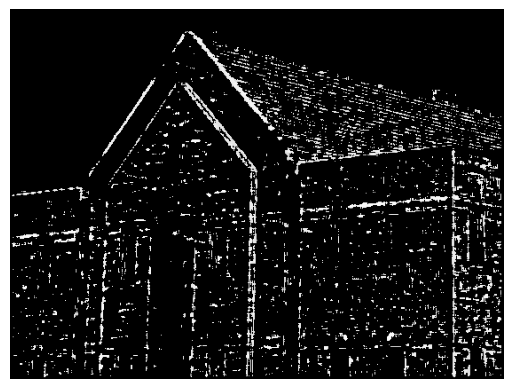

In [269]:
result_image = crossing(laplacian, threshold=200)

show_grayscale_image(plt, result_image)

6. Dobierz parametry (rozmiar filtru Gaussa, odchylenie standardowe, próg binaryzacji) tak, by widoczne były kontury domu, ale nie dachówki.


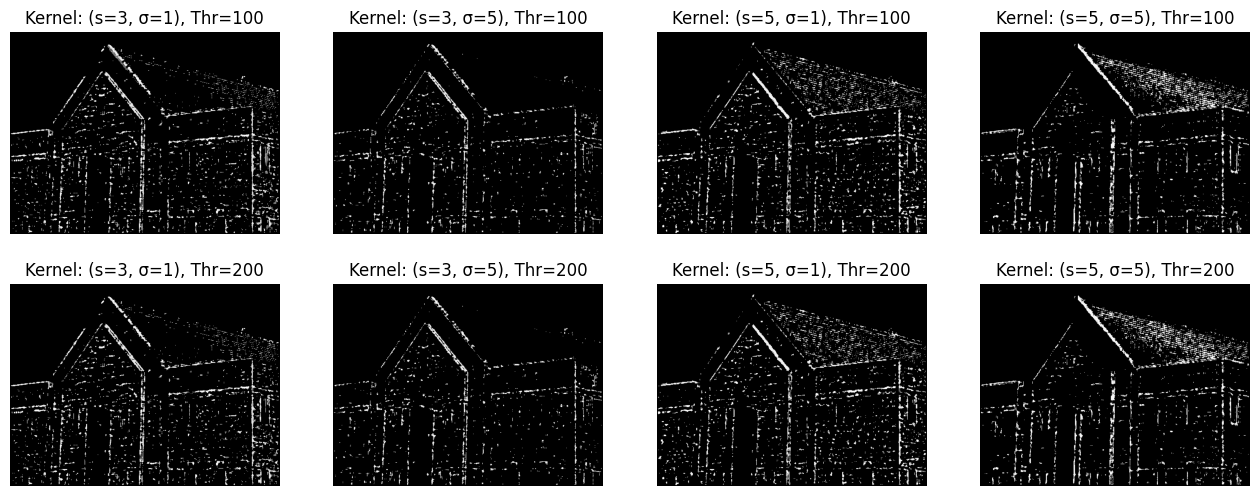

In [270]:
import itertools


def find_borders(
    image,
    gaussian_blur_kernel_size=3,
    gaussian_blur_sigma=0,
    crossing_threshold=200,
):
    blurred_image = cv2.GaussianBlur(
        image,
        ksize=(lambda x: (x, x))(gaussian_blur_kernel_size),
        sigmaX=gaussian_blur_sigma,
    )
    laplacian = cv2.Laplacian(blurred_image, ddepth=cv2.CV_32F)

    return crossing(laplacian, threshold=crossing_threshold)


GAUSSIAN_BLUR_KERNEL_SIZES = [3, 5]
GAUSSIAN_BLUR_SIGMAS = [10, 50]
CROSSING_THRESHOLD = [100, 150, 200]


def show_hiperparameter_impact(
    image, gaussian_blur_kernel_sizes, gaussian_blur_sigmas, crossing_thresholds
):
    number_of_rows = len(crossing_thresholds)
    number_of_columns = len(gaussian_blur_kernel_sizes) + len(gaussian_blur_sigmas)

    fig, axs = plt.subplots(
        nrows=number_of_rows,
        ncols=number_of_columns,
        figsize=(4 * number_of_columns, 3 * number_of_rows),
    )

    for ax_row, threshold in zip(axs, crossing_thresholds):
        for ax, (k_size, k_sigma) in zip(
            ax_row,
            list(itertools.product(gaussian_blur_kernel_sizes, gaussian_blur_sigmas)),
        ):
            borders_image = find_borders(image, k_size, k_sigma, threshold)
            show_grayscale_image(
                ax,
                borders_image,
                title=f"Kernel: (s={k_size}, σ={k_sigma}), Thr={threshold}",
            )


show_hiperparameter_impact(
    image=house_image,
    gaussian_blur_kernel_sizes=[3, 5],
    gaussian_blur_sigmas=[1, 5],
    crossing_thresholds=[100, 200],
)

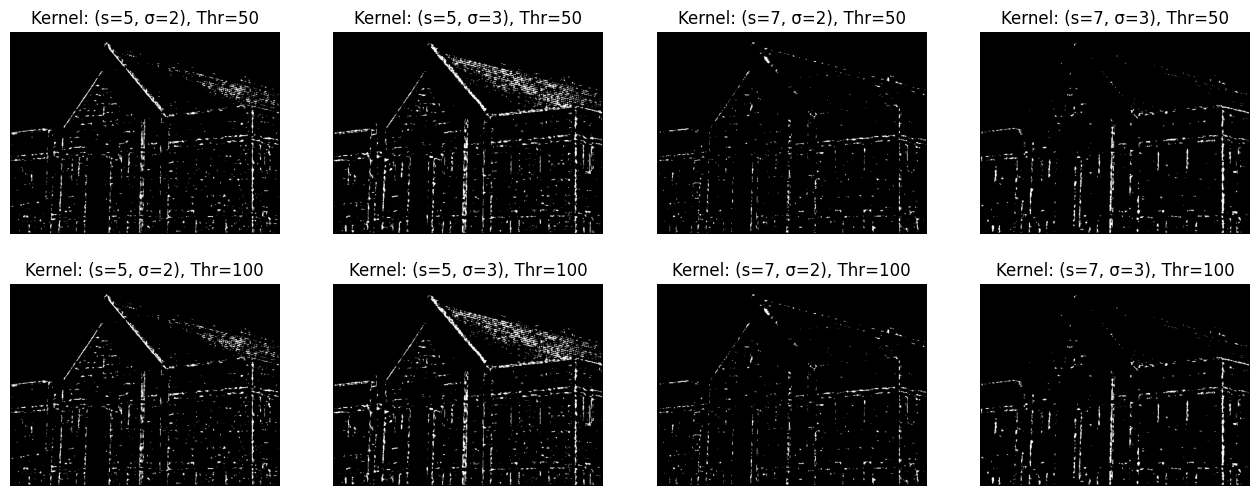

In [271]:
show_hiperparameter_impact(
    image=house_image,
    gaussian_blur_kernel_sizes=[5, 7],
    gaussian_blur_sigmas=[2, 3],
    crossing_thresholds=[50, 100],
)

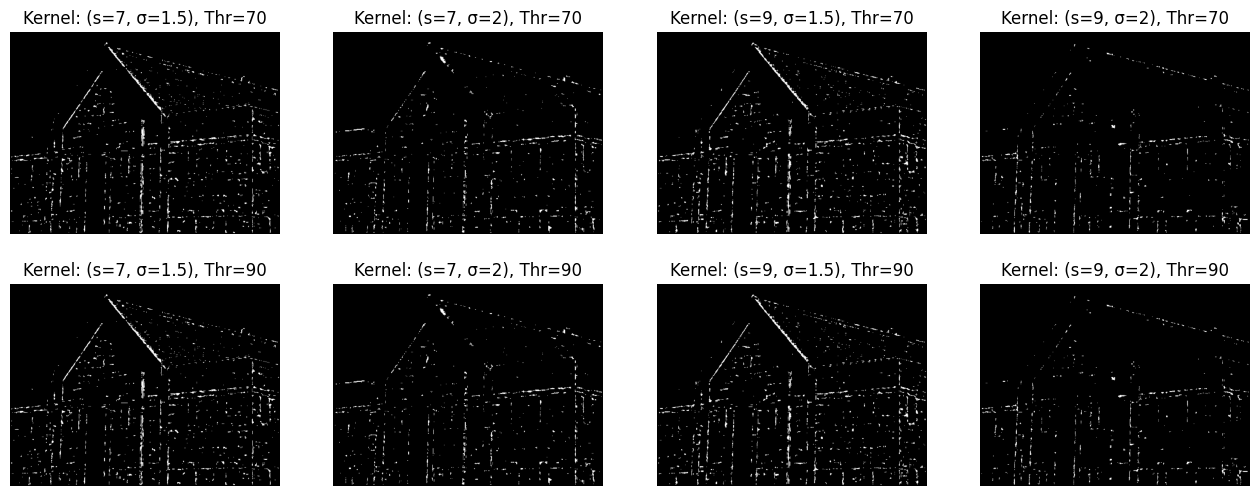

In [272]:
show_hiperparameter_impact(
    image=house_image,
    gaussian_blur_kernel_sizes=[7, 9],
    gaussian_blur_sigmas=[1.5, 2],
    crossing_thresholds=[70, 90],
)

## Algorytm Canny'ego

> Algorytm Canny'ego to często wykorzystywana metoda detekcji krawędzi.
> Zaproponowana została w 1986r. przez Johna F. Cannego.
> Przy jego projektowaniu założono trzy cele:
>
> - niska liczba błędów - algorytm powinien znajdywać wszystkie krawędzie oraz generować jak najmniej fałszywych detekcji,
> - punkty krawędziowe powinny być poprawnie lokalizowane - wykryte punkty powinny być jak najbardziej zbliżone do rzeczywistych,
> - krawędzie o szerokości 1 piksela - algorytm powinien zwrócić jeden punkt dla każdej rzeczywistej krawędzi.

Zaimplementuj algorytm detekcji krawędziCanny'ego:

1. W pierwszym kroku obraz przefiltruj dwuwymiarowym filtrem Gaussa.
2. Następnie oblicz gradient pionowy i poziomy ($g_x $ i $g_y$).
   Jedną z metod jest filtracja Sobela.
3. Dalej oblicz amplitudę:
   $M(x,y)  = \sqrt{g_x^2+g_y^2}$ oraz kąt:
   $\alpha(x,y) = arctan(\frac{g_y}{g_x})$.
   Do obliczenia kąta wykorzystaj funkcję `np.arctan2(x1, x2)`.
   Wynik jest w radianach.
4. W kolejnym etapie wykonaj kwantyzację kątów gradientu.
   Kąty od $-180^\circ$ do $180^\circ$ można podzielić na 8 przedziałów:
   [$-22.5^\circ, 22.5^\circ$], [$22.5^\circ, 67.5^\circ$],
   [$67.5^\circ, 112.5^\circ$], [$112.5^\circ, 157.5^\circ$],
   [$157.5^\circ, -157.5^\circ$], [$-157.5^\circ, -112.5^\circ$],
   [$-112.5^\circ, -67.5^\circ$], [$-67.5^\circ, -22.5^\circ$].
   Przy czym należy rozpatrywać tylko 4 kierunki: - pionowy ($d_1$), - poziomy ($d_2$), - skośny lewy ($d_3$), - skośny prawy ($d_4$).
5. Dalej przeprowadź eliminację pikseli, które nie mają wartości maksymalnej (ang. _nonmaximal suppresion_).
   Celem tej operacji jest redukcja szerokości krawędzi do rozmiaru 1 piksela.
   Algorytm przebiega następująco.
   W rozpatrywanym otoczeniu o rozmiarze $3 \times 3$: - określ do którego przedziału należy kierunek gradientu piksela centralnego ($d_1, d_2, d_3, d_4$). - przeanalizuje sąsiadów leżących na tym kierunku.
   Jeśli choć jeden z nich ma amplitudę większą niż piksel centralny, to należy uznać, że nie jest lokalnym maksimum i do wyniku przypisać $g_N(x,y) = 0$.
   W przeciwnym przypadku $g_N(x,y) = M(x,y)$.
   Przez $g_N$ rozumiemy obraz detekcji lokalnych maksimów.
   Zaimplementuj funkcję `nonmax`.
   Pierwszym argementem jest macierz kierunków (po kwantyzacji).
   Drugim argumentem jest macierz amplitudy.
6. Ostatnią operacją jest binaryzacja obrazu $g_N$.
   Stosuje się tutaj tzw. binaryzację z histerezą.
   Wykorzystuje się w niej dwa progi: $T_L$ i $T_H$, przy czym $T_L < T_H$.
   Canny zaproponował, aby stosunek progu wyższego do niższego był jak 3 lub 2 do 1.
   Rezultaty binaryzacji można opisać jako:<br>
   $g_{NH}(x,y) = g_N(x,y) \geq TH $<br>
   $g*{NL}(x,y) = TH > g_N(x,y) \geq TL $<br>
   Można powiedzieć, że na obrazie $g*{NH}$ są "pewne" krawędzie.
   Natomiast na $g*{NL}$ "potencjalne".
   Często krawędzie "pewne" nie są ciągłe.
   Dlatego wykorzystuje się obraz $g*{NL}$ w następującej procedurze: - Stwórz stos zawierający wszystkie piksele zaznaczone na obrazie $g*{NH}$.
   W tym celu wykorzystaj listę współrzędnych `[row, col]`.
   Do pobrania elementu z początku służy metoda `list.pop()`.
   Do dodania elementu na koniec listy służy metoda `list.append(new)`. - Stwórz obraz, który będzie zawierał informację czy dany piksel został już odwiedzony. - Stwórz obraz, któy zawierać będzie wynikowe krawędzie.
   Jej rozmiar jest równy rozmiarowi obrazu. - Wykonaj pętlę, która będzie pobierać elementy z listy, dopóki ta nie będzie pusta.
   W tym celu najlepiej sprawdzi się pętla `while`. - W każdej iteracji pobierz element ze stosu. - Sprawdź czy dany element został już odwiedzony. - Jeśli nie został, to: - Oznacz go jako odwiedzony, - Oznacz piksel jako krawędź w wyniku, - Sprawdź otoczenie piksela w obrazie $g_{NL}$, - Dodaj do stosu współrzędne otoczenia, które zawierają krawędź (potencjalną).
   Można to wykoanać np. pętlą po stworzonym otoczeniu.
7. Wyświetl obraz oryginalny, obraz $g_{NH}$ oraz obraz wynikowy.

Pomocnicze obrazy $g_{NH}$ i $g_{NL}$ zostały wprowadzone dla uproszczenia opisu.
Algorytm można zaimplementować wbardziej "zwarty" sposób.

Na podstawie powyższego opisu zaimplementuj algorytm Cannego.


In [273]:
from collections import deque


def extract_directions(phase):
    DISCRETIZATION_SIZE = math.pi / 4

    # Everything is rotated 22.5° right
    phase = phase + (DISCRETIZATION_SIZE / 2)

    # Negative degrees are rotated: [-180°, 180°] => [0°, 180°]
    phase = (phase + 2 * math.pi) % math.pi

    phase = phase + (DISCRETIZATION_SIZE / 2)
    directions = np.round(phase / DISCRETIZATION_SIZE).astype(np.int16)
    directions = np.minimum(4, np.maximum(1, directions))

    return directions


def nonmax(amplitude, directions):
    height, width = amplitude.shape

    def is_max_in_surrounding(y, x):
        dy, dx = {
            1: (0, 1),
            2: (1, 1),
            3: (1, 0),
            4: (1, -1),
        }[directions[y, x]]

        surrounding_points = [
            (y2, x2) for (y2, x2) in [(y + dy, x + dx), (y - dy, x - dx)]
        ]
        surrounding = [
            amplitude[y2, x2]
            for (y2, x2) in surrounding_points
            if 0 <= y2 < height and 0 <= x2 < width
        ]

        return amplitude[y, x] >= np.max(surrounding)

    result = np.zeros(shape=amplitude.shape, dtype=amplitude.dtype)
    for y in range(height):
        for x in range(width):
            if is_max_in_surrounding(y, x):
                result[y, x] = amplitude[y, x]
    return result


def bfs(nh_image, nl_image):
    def extract_points(array):
        indices = np.where(nh_image)
        return list(zip(indices[0], indices[1]))

    height, width = nh_image.shape
    result_image = nh_image.copy()
    was_visited = np.zeros(shape=nh_image.shape, dtype=bool)
    points_queue = deque()

    # to_visit_init = np.zeros(shape=nh_image.shape, dtype=bool)
    for point in extract_points(nh_image):
        points_queue.append(point)

    while len(points_queue) > 0:
        (y, x) = points_queue.popleft()
        if was_visited[y, x]:
            continue

        was_visited[y, x] = True
        result_image[y, x] = True
        for y2 in range(max(0, y - 1), min(height, y + 2)):
            for x2 in range(max(0, x - 1), min(width, x + 2)):
                if not was_visited[y2, x2] and nl_image[y2, x2]:
                    points_queue.append((y2, x2))

    return result_image


def canny(
    image,
    nh_threshold=200,
    nl_threshold=None,
):
    if nl_threshold == None:
        nl_threshold = nh_threshold / 3

    gradient_x = cv2.Sobel(image, ddepth=cv2.CV_32F, dx=1, dy=0)
    gradient_y = cv2.Sobel(image, ddepth=cv2.CV_32F, dx=0, dy=1)

    amplitude = np.sqrt(gradient_x**2 + gradient_y**2)
    phase = np.arctan2(gradient_y, gradient_x)

    directions = extract_directions(phase)
    filtered_amplitude = nonmax(amplitude, directions)

    nh_image = filtered_amplitude >= nh_threshold
    nl_image = (nh_threshold > filtered_amplitude) & (
        filtered_amplitude >= nl_threshold
    )

    result_image = bfs(nh_image, nl_image)

    return result_image, nh_image, nl_image

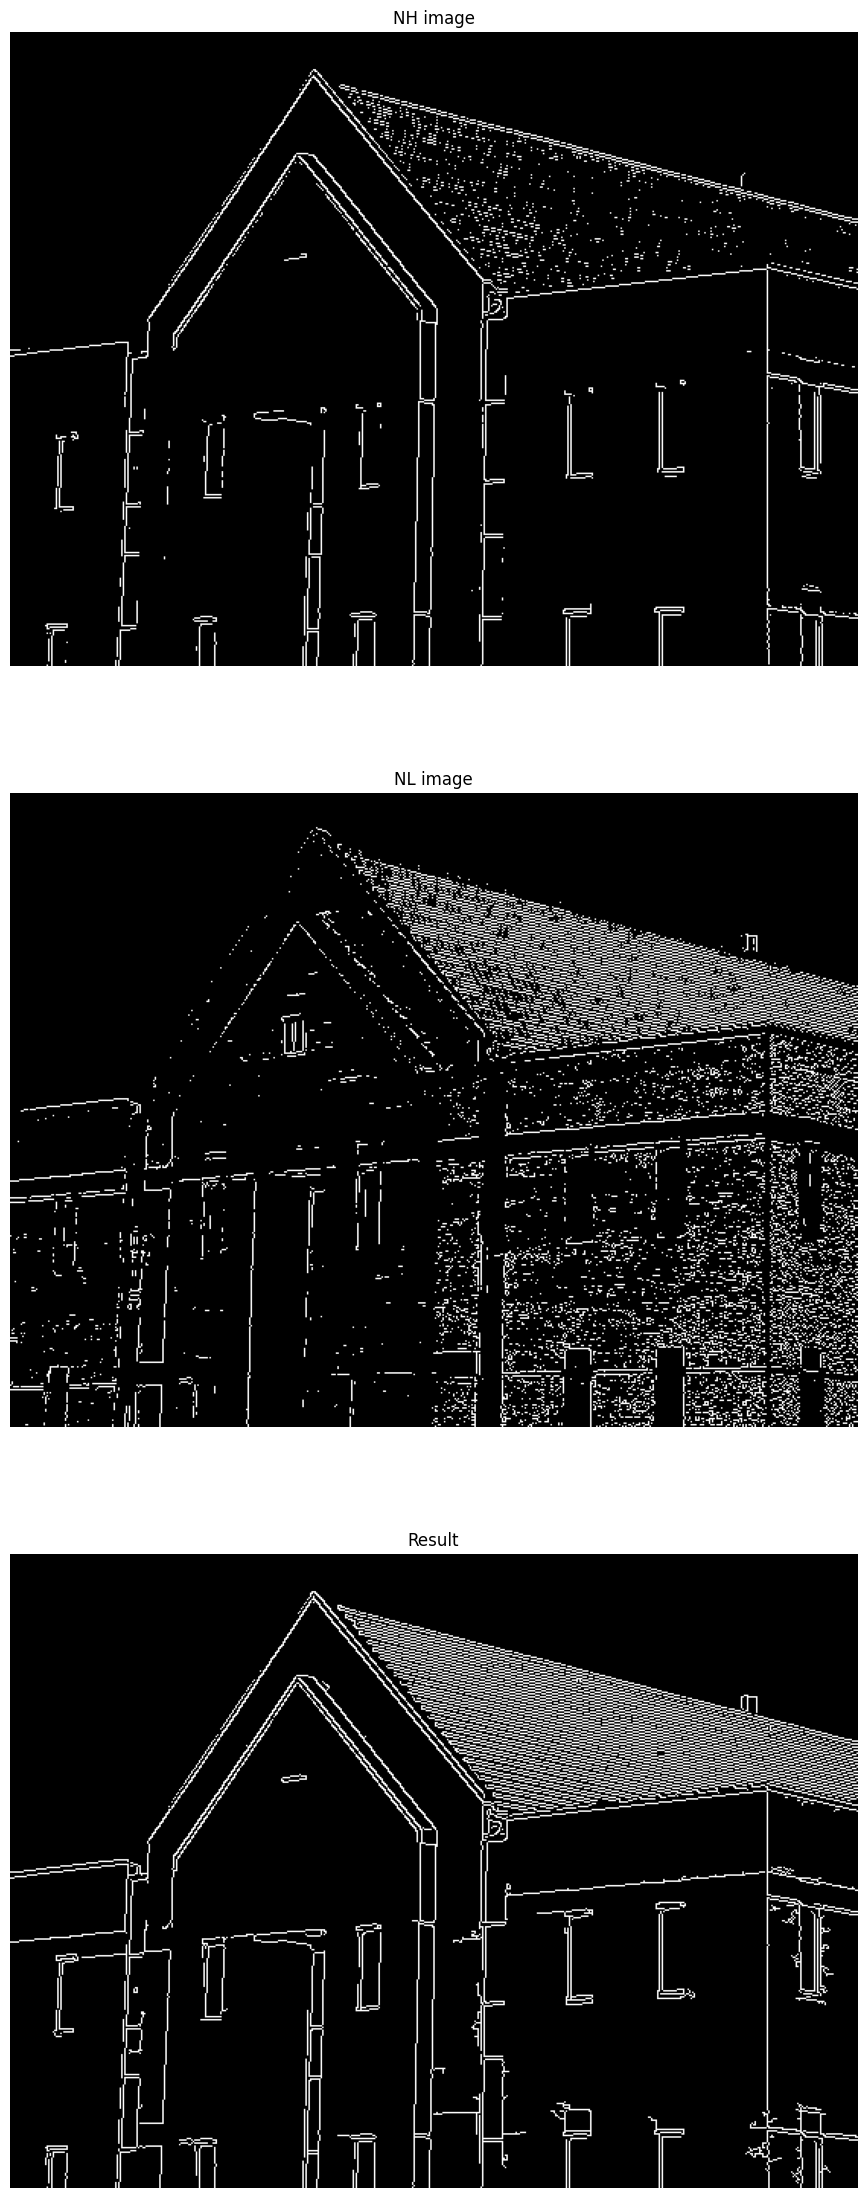

In [274]:
result_image, nh_image, nl_image = canny(house_image, nh_threshold=250)

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(13, 28))
show_grayscale_image(ax1, nh_image, title="NH image")
show_grayscale_image(ax2, nl_image, title="NL image")
show_grayscale_image(ax3, result_image, title="Result")

## Algorytm Canny'ego - OpenCV

1. Wykonaj dektekcję krawędzi metodą Canny'ego wykorzystując funkcję `cv2.Canny`.
   - Pierwszym argumentem funkcji jest obraz wejściowy.
   - Drugim argumentem jest mniejszy próg.
   - Trzecim argumentem jest większy próg.
   - Czwarty argument to tablica, do której wpisany zostanie wynik.
     Można zwrócić go przez wartość i podać wartość `None`.
   - Piąty argument to rozmiar operatora Sobela (w naszym przypadku 3).
   - Szósty argument to rodzaj używanej normy.
     0 oznacza normę $L_1$, 1 oznacza normę $L_2$. Użyj $L_2$.
2. Wynik wyświetl i porównaj z własną implementacją.


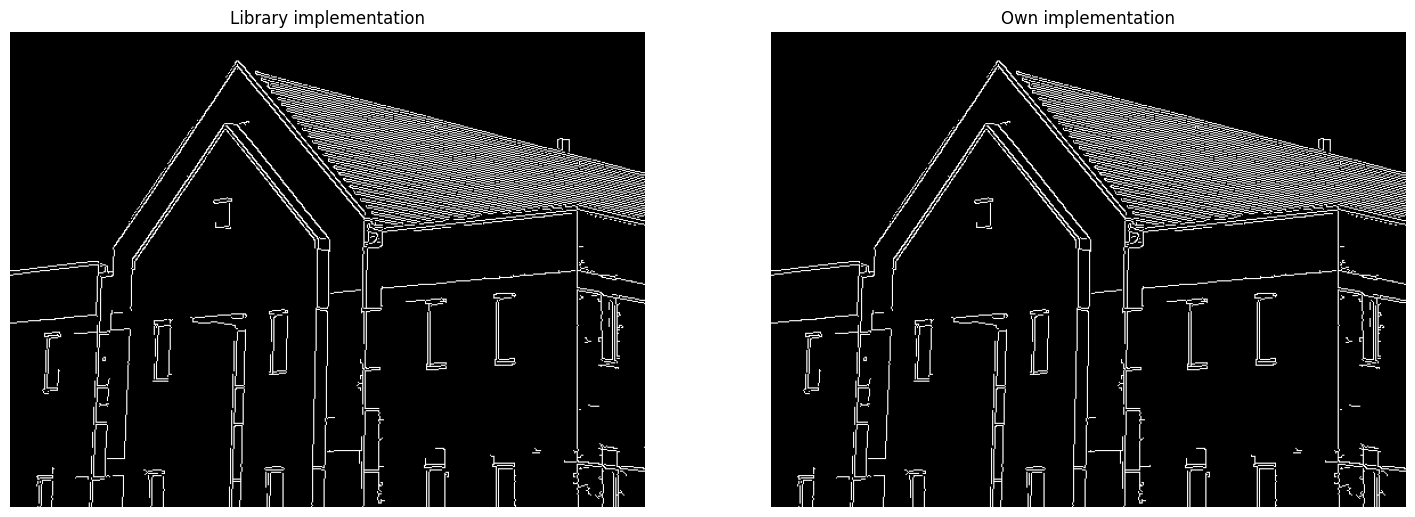

In [275]:
NH_THRESHOLD = 200
NL_THRESHOLD = 100

library_implementation_image = cv2.Canny(
    image=house_image,
    threshold1=NL_THRESHOLD,
    threshold2=NH_THRESHOLD,
    edges=None,
    apertureSize=3,
    L2gradient=True,
)

own_implementation_image, _, _ = canny(
    image=house_image,
    nh_threshold=NH_THRESHOLD,
    nl_threshold=NL_THRESHOLD,
)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 8))
show_grayscale_image(ax1, library_implementation_image, title="Library implementation")
show_grayscale_image(ax2, own_implementation_image, title="Own implementation")